In [1]:
from active_model import MLP
import active_model
import generate_data
import numpy as np
import math
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


In [2]:
raw_data, options = generate_data.load_data()

dims of (x, y) are (11, 3)
there are 6 different conditions


In [3]:
hidden_dim = [32,32]
num_task = 6
spectral_norms = [False]*len(hidden_dim)
data_model = MLP(options["dim_x"], 6, hidden_dim, spectral_norms, num_task, True, False)

## Best

### Training

In [4]:
shared_features = options["features"]
v = [1,0,0,0,0,0]

In [5]:
best_epoch_loss = []
best_predict_loss = []
test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, test_label)
for sample_size in np.arange(100,5000,100):
  hidden_dim = [32,32]
  spectral_norms = [False]*len(hidden_dim)
  best_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
  optimizer = optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=100, gamma=0.9) 
  train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  M = sample_size
  L = 1.1   # base length
  K = 70   # model dimension
  epoch = int(math.log(K*M,L))
  total_loss = 0
  for i in range(epoch):
    total_loss += active_model.train_source(best_model, train_dataset, 6, optimizer, i, False)
    # scheduler.step()
  best_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(best_model.predict(test_dataset[0],test_dataset[1],k))
  best_predict_loss.append(predict_loss)


Text(0.5, 1.0, 'best sampling training loss')

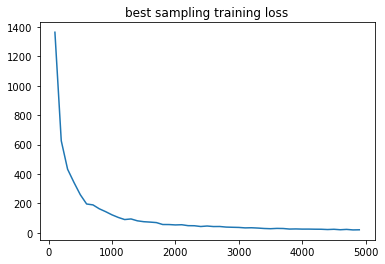

In [6]:
plt.plot(np.arange(100,5000, 100),best_epoch_loss)
plt.title("best sampling training loss")

### Predict on target

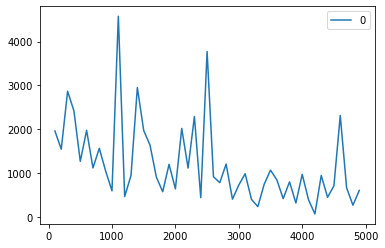

In [9]:
plt.plot(np.arange(100,5000, 100), np.array(best_predict_loss).T[0], label=0)
plt.legend()
plt.show()

## Uniform

In [10]:
num_task = 6
shared_features = options["features"]
v = np.array([1]*len(raw_data))
v = v / (len(raw_data))
sample_size = 500

In [10]:
train_dataset, test_dataset = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)

In [11]:
# M = len(train_dataset[0])
# L = 50   # base length
# K = 32   # model dimension
# epoch = int(math.log(K*M,L))
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
uni_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
optimizer = optim.SGD(uni_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=200, gamma=0.9)

In [ ]:
uni_epoch_loss = []
uni_predict_loss = []
test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, test_label)
for sample_size in np.arange(100,5000, 100):  
  hidden_dim = [32,32]
  spectral_norms = [False]*len(hidden_dim)
  uni_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
  optimizer = optim.SGD(uni_model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
  train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  M = sample_size
  L = 1.1   # base length
  K = 70   # model dimension
  epoch = int(math.log(K*M,L))
  total_loss = 0
  for i in range(epoch):
    total_loss += active_model.train_source(uni_model, train_dataset, 6, optimizer, i, True)
    scheduler.step()
  uni_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(uni_model.predict(test_dataset[0],test_dataset[1],k))
  uni_predict_loss.append(predict_loss)
  

Text(0.5, 1.0, 'uniform sampling training loss')

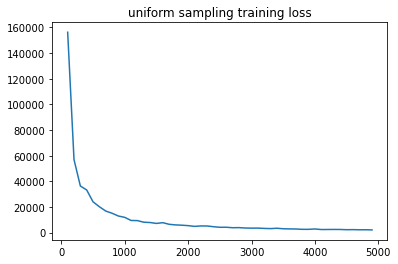

In [13]:
plt.plot(np.arange(100,5000, 100),uni_epoch_loss)
plt.title("uniform sampling training loss")

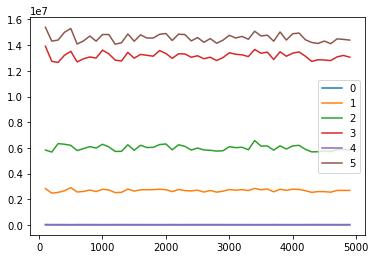

In [19]:
for k in range(num_task):
    plt.plot(np.arange(100,5000, 100), np.array(uni_predict_loss).T[k], label=k)
plt.legend()
plt.show()

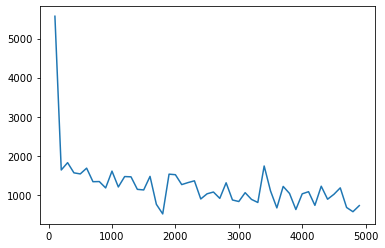

In [20]:
plt.plot(np.arange(100,5000, 100), np.array(uni_predict_loss).T[0], label=0)

## Compare

Text(0.5, 1.0, 'Compare Training Loss')

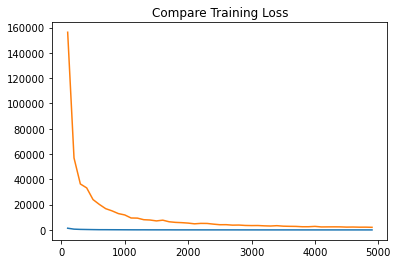

In [14]:
plt.plot(np.arange(100,5000, 100),best_epoch_loss)
plt.plot(np.arange(100,5000, 100),uni_epoch_loss)
plt.title("Compare Training Loss")

Text(0.5, 1.0, 'Compare Testing Loss')

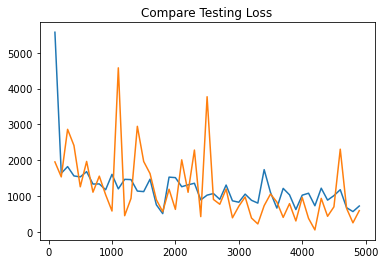

In [21]:
plt.plot(np.arange(100,5000, 100), np.array(uni_predict_loss).T[0], label="uniform 0")
plt.plot(np.arange(100,5000, 100), np.array(best_predict_loss).T[0], label="best 0")
plt.title("Compare Testing Loss")